<a href="https://colab.research.google.com/github/Nimalesh/L2i/blob/main/StyleSpace_advance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get localized channels and attribute specific channels


In [2]:
#@title Setup (may take a few minutes)
# %tensorflow_version 1.x
!git clone https://github.com/betterze/StyleSpace
%cd /content/StyleSpace

fatal: destination path 'StyleSpace' already exists and is not an empty directory.
/content/StyleSpace


In [3]:
# Look for tf.Session
!grep -rnw '.' -e 'tf.Session'

# Look for tf.placeholder
!grep -rnw '.' -e 'tf.placeholder'

# Look for tf.global_variables_initializer
!grep -rnw '.' -e 'tf.global_variables_initializer'

# Look for tf.contrib (deprecated)
!grep -rnw '.' -e 'tf.contrib'

# Look for tf.layers (replace with tf.keras.layers)
!grep -rnw '.' -e 'tf.layers'

# Optional: look for any use of TensorFlow
!grep -rnw '.' -e 'import tensorflow'


grep: ./dnnlib/tflib/__pycache__/tfutil.cpython-37.pyc: binary file matches
./dnnlib/tflib/tfutil.py:151:def create_session(config_dict: dict = None, force_as_default: bool = False) -> tf.Session:
./dnnlib/tflib/tfutil.py:152:    """Create tf.Session based on config dict."""
./dnnlib/tflib/tfutil.py:165:    session = tf.Session(config=config_proto)
./GetCode.py:48:    with tf.Session() as sess:
./GetCode.py:144:    with tf.Session() as sess:
./dnnlib/tflib/autosummary.py:112:                    update_value = tf.placeholder(_dtype)
./dnnlib/tflib/network.py:148:                    self._input_templates.append(tf.placeholder(tf.float32, name=param.name))
./dnnlib/tflib/network.py:589:                    in_expr = [tf.placeholder(tf.float32, name=name) for name in self.input_names]
./dnnlib/tflib/tfutil.py:222:                    setter = tf.assign(var, tf.placeholder(var.dtype, var.shape, "new_value"), name="setter")  # create new setter
./invert_mask.py:220:    model_input=tf.placehold

In [7]:
dataset_name='ffhq' #only support ffhq
# input prepare data
!python GetCode.py --dataset_name $dataset_name --code_type 'w'
!python GetCode.py --dataset_name $dataset_name --code_type 's'
!python GetCode.py --dataset_name $dataset_name --code_type 's_mean_std'

import matplotlib.pyplot as plt
import numpy as np
import pickle
from PIL import Image
from MAdvance import MAdvance
M=MAdvance(dataset_name=dataset_name)

with open(M.img_path+'grad_example', 'rb') as handle:
        grads = pickle.load(handle)

2025-05-11 08:47:05.425818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746953225.447273    5790 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746953225.453338    5790 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
output_path: ./npy/ffhq
Traceback (most recent call last):
  File "/content/StyleSpace/GetCode.py", line 199, in <module>
    dlatents = GetCode(Gs, random_state, num_img, num_once, truncation)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/StyleSpace/GetCode.py", line 86, in GetCode
    dlatent_avg = Gs.get_var('dlatent_avg')
                  ^^^^^^^^^^
AttributeError: 'Network' object has 

FileNotFoundError: [Errno 2] No such file or directory: './npy/ffhq/S'

# gradient map of a single channel



(-0.5, 255.5, 255.5, -0.5)

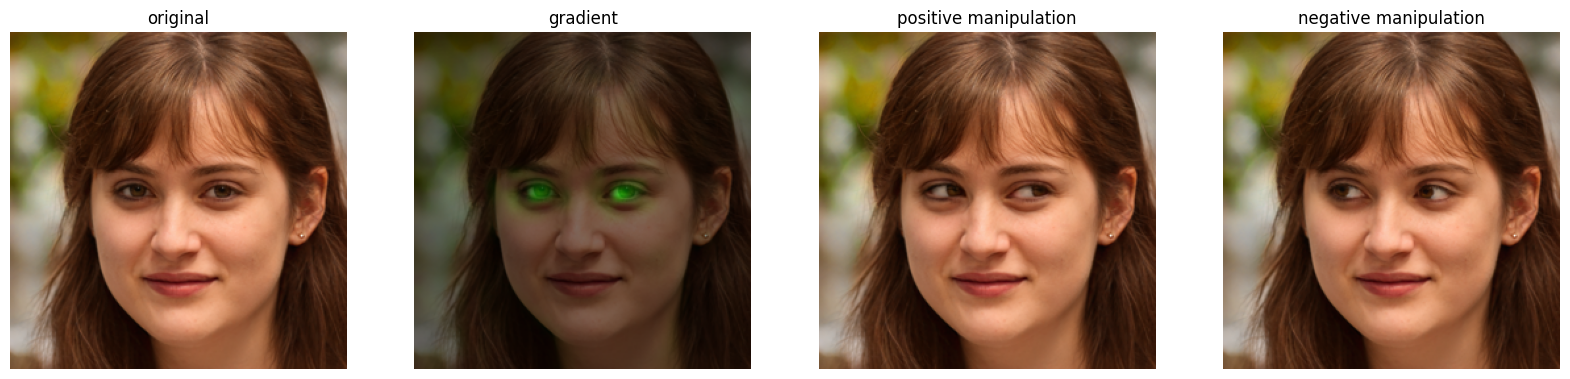

In [ ]:
img_index='0' #@param [0,1,2,3,4,5,6,7,8,9]
img_index=int(img_index)
LayerIndex_ChannelIndex='9_409' #@param ['12_266','11_286','3_169','6_83','6_501','15_45','9_409','9_376','8_28']
manipulation_strength='5' #@param [3, 5, 10, 15]
alpha=int(manipulation_strength)

tmp=LayerIndex_ChannelIndex.split('_')
lindex,cindex=int(tmp[0]),int(tmp[1])
grad=grads[lindex][img_index,cindex]
tmp=np.zeros([32,32,3]).astype('uint8')
tmp[:,:,1]=grad
grad1=Image.fromarray(tmp).resize((256,256))

M.alpha=[0]
M.img_index=img_index
M.num_images=1
M.manipulate_layers=[lindex]
codes,out=M.EditOneC(cindex)
original=Image.fromarray(out[0,0]).resize((256,256))

original = original.convert("RGBA")
grad1 = grad1.convert("RGBA")
new_img = Image.blend(original, grad1, 0.5)

M.alpha=[-alpha,alpha]
M.manipulate_layers=[lindex]
codes,out=M.EditOneC(cindex)
positive=Image.fromarray(out[0,1]).resize((256,256))
negative=Image.fromarray(out[0,0]).resize((256,256))

plt.figure(figsize=(20,5), dpi= 100)
plt.subplot(1,4,1)
plt.imshow(original)
plt.title('original')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(new_img)
plt.title('gradient')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(positive)
plt.title('positive manipulation')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(negative)
plt.title('negative manipulation')
plt.axis('off')

# show localized channels
For each semantic area, we show the most localized channles in this area, measured by IoU between semantic map and gradient map. The layer index and channel index is on the y label of each row.


number of localized channels in this area 393


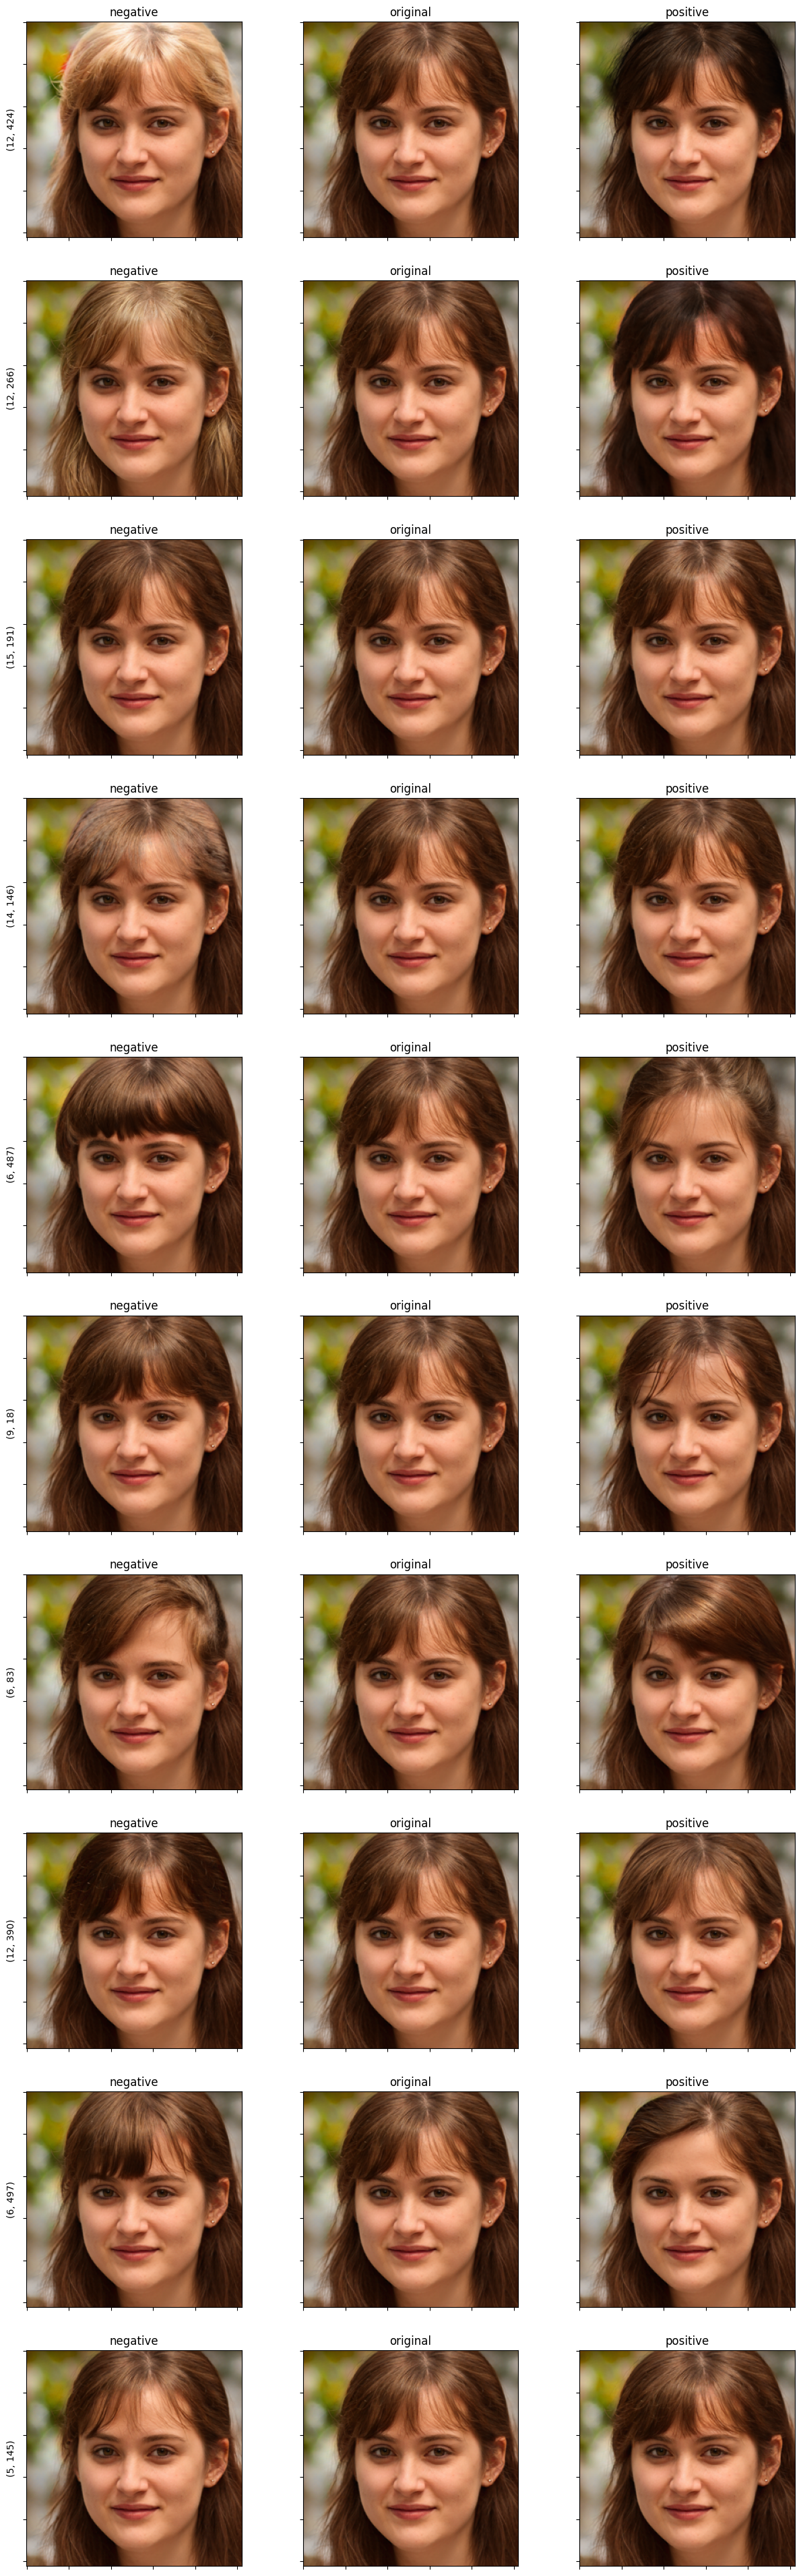

In [ ]:
area='hair' #@param ['eyebrow','eye','ear', 'nose', 'mouth', 'neck', 'clothes', 'hair']
number_channel_to_view='10' #@param [ 10, 15, 20]
num_view=int(number_channel_to_view)

img_index='0' #@param [0,1,2,3,4,5,6,7,8,9]
img_index=int(img_index)
manipulation_strength='10' #@param [ 5, 10, 15,20]
alpha=int(manipulation_strength)

tmp=list(M.label.values).index(area)
target_index=(tmp,)
lp_candidate,_=M.GetRank(target_index)
print('number of localized channels in this area',lp_candidate.shape[0])

M.alpha=[0]
M.img_index=img_index
M.num_images=1
M.manipulate_layers=[0]
codes,out=M.EditOneC(0)
original=Image.fromarray(out[0,0]).resize((256,256))

M.alpha=[-alpha,alpha]
imgs=[]

for i in range(num_view):
  lindex,cindex,_=lp_candidate[i]
  lindex,cindex=int(lindex),int(cindex)
  M.manipulate_layers=[lindex]
  codes,out=M.EditOneC(cindex)
  imgs.append(out)
imgs=np.concatenate(imgs)

plt.figure(figsize=(15,5*num_view), dpi= 100)
tmp_index=1
for i in range(num_view):
  plt.subplot(num_view,3,tmp_index)
  lindex,cindex,rate=lp_candidate[i]
  #rate=round(rate,2)
  tmp=(int(lindex),int(cindex))
  plt.ylabel(str(tmp))
  img=Image.fromarray(imgs[i,0]).resize((256,256))
  plt.imshow(img)
  plt.title('negative')
  plt.gca().axes.yaxis.set_ticklabels([])
  plt.gca().axes.xaxis.set_ticklabels([])
  tmp_index+=1

  plt.subplot(num_view,3,tmp_index)
  plt.imshow(original)
  plt.title('original')
  plt.gca().axes.yaxis.set_ticklabels([])
  plt.gca().axes.xaxis.set_ticklabels([])
  tmp_index+=1

  plt.subplot(num_view,3,tmp_index)
  img=Image.fromarray(imgs[i,1]).resize((256,256))
  plt.imshow(img)
  plt.title('positive')
  plt.gca().axes.yaxis.set_ticklabels([])
  plt.gca().axes.xaxis.set_ticklabels([])
  tmp_index+=1





# attribute specific channels
Given a set of examplar images that contain a certain attribute (for example, smiling), we design a simple algorithm based on signal2noise ratio to detect the channels that control this attribute. Large S2N means this channel has large potential to control target attribute.


bname: goatee


Text(0.5, 0, '(layer_index, channel_index)')

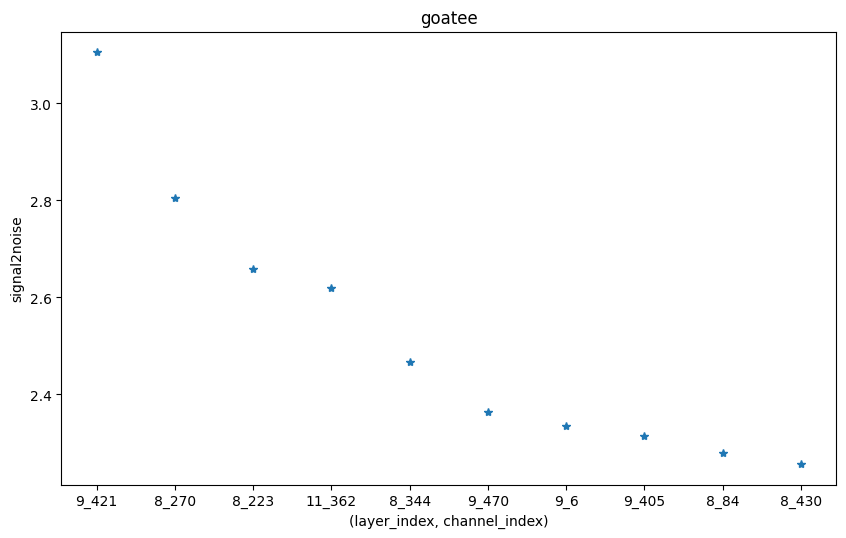

In [ ]:

attribute='goatee' #@param['male', 'smiling', 'wavy-hair','bald', 'bangs', 'black-hair', 'blond-hair', 'eyeglasses', 'goatee', 'gray-hair', 'receding-hairline', 'sideburns',  'wearing-earrings', 'wearing-lipstick', 'wearing-necktie']

M.bname=attribute
lp_candidate,lp_sort= M.AllCheck()
plt.figure(figsize=(10,6), dpi= 100)
plt.title(M.bname)
plt.plot(lp_sort[:10],'*')
plt.ylabel('signal2noise')
plt.xlabel('(layer_index, channel_index)')


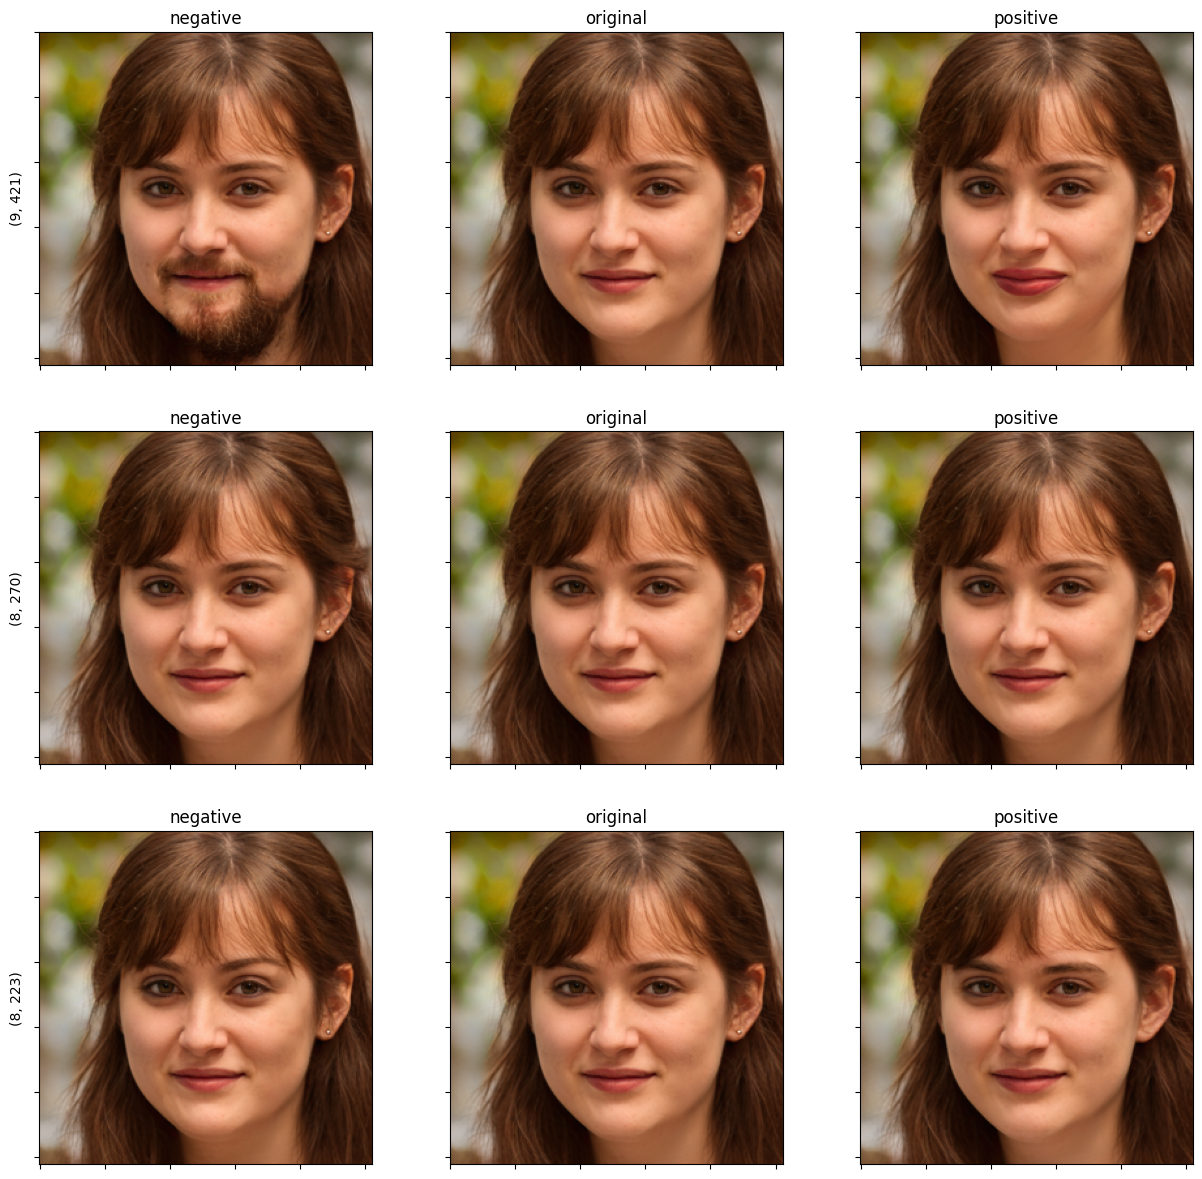

In [ ]:
number_channel_to_view='3' #@param [3, 5, 10]
num_view=int(number_channel_to_view)

img_index='0' #@param [0,1,2,3,4,5,6,7,8,9]
img_index=int(img_index)
manipulation_strength='5' #@param [ 5, 10, 15,20]
alpha=int(manipulation_strength)



M.alpha=[0]
M.img_index=img_index
M.num_images=1
M.manipulate_layers=[0]
codes,out=M.EditOneC(0)
original=Image.fromarray(out[0,0]).resize((256,256))

M.alpha=[-alpha,alpha]
imgs=[]

for i in range(num_view):
  lindex,cindex,_=lp_candidate[i]
  lindex,cindex=int(lindex),int(cindex)
  M.manipulate_layers=[lindex]
  codes,out=M.EditOneC(cindex)
  imgs.append(out)
imgs=np.concatenate(imgs)

plt.figure(figsize=(15,5*num_view), dpi= 100)
tmp_index=1
for i in range(num_view):
  plt.subplot(num_view,3,tmp_index)
  lindex,cindex,rate=lp_candidate[i]
  #rate=round(rate,2)
  tmp=(int(lindex),int(cindex))
  plt.ylabel(str(tmp))
  img=Image.fromarray(imgs[i,0]).resize((256,256))
  plt.imshow(img)
  plt.title('negative')
  plt.gca().axes.yaxis.set_ticklabels([])
  plt.gca().axes.xaxis.set_ticklabels([])
  tmp_index+=1

  plt.subplot(num_view,3,tmp_index)
  plt.imshow(original)
  plt.title('original')
  plt.gca().axes.yaxis.set_ticklabels([])
  plt.gca().axes.xaxis.set_ticklabels([])
  tmp_index+=1

  plt.subplot(num_view,3,tmp_index)
  img=Image.fromarray(imgs[i,1]).resize((256,256))
  plt.imshow(img)
  plt.title('positive')
  plt.gca().axes.yaxis.set_ticklabels([])
  plt.gca().axes.xaxis.set_ticklabels([])
  tmp_index+=1



